In [29]:
import numpy as np
from tqdm.auto import tqdm

from scipy.optimize import minimize

import pandas as pd
import geopandas as gpd
import wbgapi as wb

import pycountry_convert
import pycountry

from matplotlib import pyplot as plt
import matplotlib.animation as animation
from matplotlib.lines import Line2D

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.impute import KNNImputer
from sklearn.feature_selection import mutual_info_regression

plt.rcParams['figure.dpi'] = 300 
plt.rcParams['savefig.dpi'] = 300

DATA_DIR = 'data/'

## Define necessary classes and functions

In [30]:
class WbDataPipeline():
    '''
    A class to pull and clean World Bank data for use in the happiness dataset
    '''

    def __init__(self, indicators, year, impute=True, missing_countries=False) -> None:
        '''
        Creates the World Bank data pipeline

        Parameters:
        indicators (list): list of World Bank indicator codes
        year (int): year to pull data from. We used 2022
        impute (bool): whether to impute missing data
        missing_countries (bool): whether to include countries not in the happiness dataset
        '''

        self.indicators = indicators
        self.year = year

        # Data from the happiness dataset had special formatting that we had to extract by hand
        self.happiness_data = pd.read_csv(DATA_DIR + 'happiness/happiness.csv').drop('Country', axis=1)
        self.valid_countries = self.happiness_data['ISO_A3'].unique()
        self.missing_countries = missing_countries
        self.impute = impute

        # Set the world bank database to the World Development Indicators
        wb.db = 2
        self.data = self.pull_data()
    
    def pull_data(self) -> pd.DataFrame:
        '''
        Pulls the World Bank data and merges it with the happiness data
        '''
        
        # Pull the data
        print(f"Pulling {len(self.indicators)} indicators from World Bank data...")
        features = wb.data.DataFrame(self.indicators, time=self.year)
        print("Done")
        features = features.reset_index()
        features = features.infer_objects()
        features = features.rename(columns={features.columns[0]: 'ISO_A3'})

        # If we only want countries in the happiness dataset
        if not self.missing_countries:
            features = features[features['ISO_A3'].isin(self.valid_countries)]

        if self.impute:
            features = self.impute_numeric_data(features)

        # Merge with happiness data
        if not self.missing_countries:
            merged = pd.merge(features, self.happiness_data, on='ISO_A3')
            return merged
        
        return features
    
    def impute_numeric_data(self, data) -> pd.DataFrame :
        '''This code fills in missing numerical data with the mean of its 5 nearest neighbors
        as determined by its nonmissing numerical data. No categorical features are 
        touched.
        
        Parameters:
        data (pd.DataFrame): the data to impute
        '''
        imputed_data = KNNImputer().fit_transform(data.iloc[:, 1:])
        data.iloc[:, 1:] = imputed_data
        return data
    
    def get_data(self) -> pd.DataFrame: 
        '''
        Getter for the data
        '''

        if self.data is None:
            self.data = self.pull_data()
        return self.data

    def check_missing(self, threshold) -> pd.Series:
        '''
        Generates a report of how many features are less than a certain percentage complete

        Parameters:
        threshold (float): the threshold for what percentage of the data must be complete
        '''

        # Sum up the number of missing values
        nans = self.data.isna().sum()

        # We are more interested in the complete percentage, but this code was originally written for missing percentage
        threshold = 1 - threshold
        nthreshold = np.round(self.data.shape[0] * threshold)
        cols = nans[nans > nthreshold]
        
        # Print the report
        print(f"The following features are less than {100*(1-threshold)}% complete:")
        for col in cols.index:
            pcomplete = 1 - (nans[col] / self.data.shape[0])
            print(f"   {col}: {pcomplete*100}% complete") 
        return cols
    
    def check_percent_complete(self) -> pd.Series:
        '''
        Returns the perentage of features that are complete
        '''
        
        nans = self.data.isna().sum()
        print(f"Percent complete: {self.get_percent_complete()}")
        return 1 - (nans / self.data.shape[0])
    
def clean_features(write_csv=None) -> pd.DataFrame:
    '''
    Function to get all of the feature data and generate csv containing
    the feature id, its description, and how complete that feature is.
    This is usefull for selecting features that dono have too many missing values

    Parameters:
    write_csv (str): the file to write the data to
    '''

    entries = []
    indicators = wb.series.list()
    
    # Get all ids and values for all of the indicators
    ids = [(str(indicator['id']), str(indicator['value'])) for indicator in indicators]

    # This can take a while so a progress bar is nice
    pbar = tqdm(total=len(ids), position=0, leave=True)
    
    for id, value in ids:
        dp = WbDataPipeline([id], 2022, impute=False)
        complete_percent = dp.get_percent_complete()[id]
        entries.append([id, value, complete_percent])
        pbar.update()
    pbar.close()

    # Return the data as a dataframe
    entries = pd.DataFrame(entries, columns=['id', 'value', 'complete_percent'])

    # Write the feature data to a file
    if write_csv is not None:
        entries.to_csv(write_csv)

    return entries

def generate_wb_dataset(complete_percent=1.0, write_csv=None, missing_countries=False) -> pd.DataFrame:
    '''
    Function to generate a dataset from the World Bank data
    '''

    # Read from the feature data file
    feature_data = pd.read_csv('feature_data.csv')
    feature_data = feature_data.infer_objects()
    features = feature_data[feature_data['complete_percent'] >= complete_percent]['id']
    
    # Get only countries satisfying the missing countries condition
    dp = WbDataPipeline(features, 2022, missing_countries=missing_countries)

    if write_csv is not None:
        dp.get_data().to_csv(write_csv)

    return dp.get_data()

# We encountered different naming conventions for countries in some of our experimental datasets.
# This function standardizes some of thse names so we can use their ISO A3 codes

def name_change(df) -> pd.DataFrame:
        '''
        Replace unusual country names and get ISO A3 codes

        Parameters:
        df (pd.DataFrame): the dataframe
        '''
        
        # Define a dictionary of all the name changes we encountered
        name_changes = {'Bolivia (Plurinational State of)' : 'Bolivia',
        'Democratic Republic of the Congo' : 'Congo, The Democratic Republic of the',
        'Iran (Islamic Republic of)':'Iran',
        'Micronesia (Federated States of)' : 'Micronesia, Federated States of',
        'Republic of Korea' : 'Korea, Republic of',
        'Swaziland' : 'Eswatini',
        'The former Yugoslav republic of Macedonia' : 'North Macedonia',
        'Turkey' : 'Türkiye',
        'Venezuela (Bolivarian Republic of)' : 'Venezuela, Bolivarian Republic of',
        'Taiwan Province of China' : 'Taiwan',
        'Kosovo' : 'Serbia',
        'North Cyprus' : 'Cyprus',
        'Russia' : 'Russian Federation',
        'Hong Kong S.A.R. of China' : 'Hong Kong',
        'Ivory Coast' : 'CI',
        'Palestinian Territories' : 'PS',
        'Eswatini, Kingdom of' : 'SZ',}
        
        # Use pycountry to get the ISO A3 code for each country
        def get_country_code(country_name):
            if country_name[-1] == '*':
                country_name = country_name[:-1]
            if country_name in name_changes:
                country_name = name_changes[country_name]
            try:
                return pycountry.countries.get(country_name).alpha_3
            except:
                try:
                    return pycountry.countries.lookup(country_name).alpha_3
                except:    
                    # If this is the case we need to manually enter the unusual country name
                    raise ValueError(f"No ISO code associated with country {country_name}")
        
        df['ISO_A3'] = df['Country'].apply(get_country_code)
        return df

In [31]:
def plot_gdp_happiness(ax, logscale=False) -> None:
    '''
    Generate the plot of GDP vs Happiness score

    Parameters:
    ax (matplotlib.pyplot.axis): the axis to plot on
    logscale (bool): whether to plot the data on a log scale
    '''
    
    # Pull the data
    wb.db = 2
    dp = WbDataPipeline(["NY.GDP.PCAP.PP.CD"], 2022, impute=False)
    data = dp.get_data()
    data = data.rename(columns={"NY.GDP.PCAP.PP.CD": "GDP"})

    # Manually enter the GDP for countries that are missing. Sourced from the World Bank but not in the dataset
    data.loc[data["ISO_A3"] == "TKM", "GDP"] = 8792.55
    data.loc[data["ISO_A3"] == "VEN", "GDP"] = 3421
    data.loc[data["ISO_A3"] == "YEM", "GDP"] = 698.95

    # Whether to plot and fit models on log scale
    if logscale:
        data["GDP"] = np.log(data["GDP"])

    # Setup data for regression
    xs = np.linspace(data['GDP'].min(), data['GDP'].max(), 1000)
    X = data['GDP'].values.reshape(-1, 1)
    Y = data['Happiness score'].values.reshape(-1, 1)

    # Fit the linear model
    model1 = LinearRegression().fit(X, Y)
    lin_preds = model1.predict(X)
    print("Linear model MSE:", mean_squared_error(Y, lin_preds))
    print("Linear model R^2:", r2_score(Y, lin_preds))

    # Define a log model
    def log_model(th, x=X):
        return th[0] * np.log(x) + th[1]
    
    # Fit the log model
    res = minimize(lambda th : np.mean((log_model(th) - Y)**2), [1, 1])
    log_params = res.x
    log_preds = log_model(log_params)
    print("Log model MSE:", mean_squared_error(Y, log_preds))
    print("Log model R^2:", r2_score(Y, log_preds))

    # Plot all of the countries colored by continent
    colors = {'EU': 'blue', 'AS': 'orange', 'AF': 'red', 'NA': 'green', 'SA': 'yellow', 'OC': 'purple'}
    for country in data['ISO_A3']:
        color = colors[pycountry_convert.country_alpha2_to_continent_code(pycountry.countries.get(alpha_3=country).alpha_2)]
        ax.scatter(data.loc[data['ISO_A3'] == country, 'GDP'], data.loc[data['ISO_A3'] == country, 'Happiness score'], marker='o', color=color, s=4)

    # Plot the models
    ax.plot(xs, model1.predict(xs.reshape(-1,1)), color='black', label='Linear Model')
    ax.plot(xs, log_model(log_params, xs.reshape(-1,1)), color='grey', label='Log Model', linestyle='--')    

    # Set the labels
    ax.set_xlabel('GDP per Capita (USD)', fontsize=6)
    ax.set_ylabel('Happiness Score', fontsize=6)
    ax.set_title('Happiness Score vs GDP per Capita', fontsize=10)
    ax.set_xticks

    # Create a custom legend
    custom_points = [Line2D([0], [0], color='black', label='Linear Model', linestyle='-'),
                    Line2D([0], [0], color='grey', label='Log Model', linestyle='--'),
                    Line2D([0], [0], color='red', marker='o', label='Africa', linestyle=''),
                    Line2D([0], [0], color='orange', marker='o', label='Asia', linestyle=''),
                    Line2D([0], [0], color='yellow', marker='o', label='Souh America', linestyle=''),
                        Line2D([0], [0], color='green', marker='o', label='North America', linestyle=''),
                        Line2D([0], [0], color='blue', marker='o', label='Europe', linestyle=''),
                        Line2D([0], [0], color='purple', marker='o', label='Oceania', linestyle=''),]
    ax.legend(handles=custom_points, loc="lower right", fontsize=6)
    ax.tick_params(axis='both', which='major', labelsize=6)
    ax.grid(True)

In [32]:
class GeoPlotter():
    '''
    Class for plotting data on a world map
    '''

    def __init__(self, df=None) -> None:
        '''
        Initializes the GeoPlotter

        Parameters:
        df (pd.DataFrame): the dataframe to plot
        '''

        if 'ISO_A3' not in df.columns:
            raise ValueError("This dataframe does not have an ISO_A3 column. Please use the DataPipeline change_name transform to prepare it for plotting")
        else: 
            self.df = df

        world = gpd.read_file(DATA_DIR + 'worldmap.gpkg')
    
        # Bug in geopandas see https://github.com/geopandas/geopandas/issues/1041
        # These values are set wrong in the world map data file
        world.loc[world['NAME_EN'] == 'France', 'ISO_A3'] = 'FRA'
        world.loc[world['NAME_EN'] == 'Norway', 'ISO_A3'] = 'NOR'
        world.loc[world['NAME_EN'] == 'Somaliland', 'ISO_A3'] = 'SOM'
        world.loc[world['NAME_EN'] == 'Kosovo', 'ISO_A3'] = 'RKS'

        # Merge the data with the world map
        self.merged = pd.merge(world, self.df, on='ISO_A3')
        self.no_data = world[~world['ISO_A3'].isin(self.df['ISO_A3'])]

    def plot(self, col_name, ax, year=None, title=None) -> None:
        '''
        Plots the data from the specified column

        Parameters:
        col_name (str): the column to plot
        ax (matplotlib.pyplot.axis): the axis to plot on
        year (str): the year to plot from (we used 2022 in our experimets)
        title (str): the title of the plot
        '''

        # Make sure data is set
        if year is None:
            df = self.merged
        else:
            df = self.merged[self.merged['Year'].astype(str) == year]

        if title is None:
            title = col_name

        # Plot the data and color missing countries grey
        df.plot(column=col_name, edgecolor="black", linewidth=0.2, ax=ax, legend=True, legend_kwds={'aspect': 30, 'shrink': 0.9})
        self.no_data.plot(ax=ax, edgecolor="grey", linewidth=0.2, color='lightgrey', legend=True)
        
        # Format the plot
        ax.set_title(title, fontsize=16)
        ax.set_axis_off()
        fig = ax.get_figure()
        cax = fig.axes[1]
        cax.set_ylabel(col_name)
    
    def animate(self, col_name, video_name)-> None:
        '''
        Animates updates of time series data. We never used this for the final product, but we used it in experiments

        Parameters:
        col_name (str): the column to animate
        video_name (str): the name of the video to save
        '''
        fig, ax = plt.subplots(1, figsize=(10, 7))

        # Updata the animation for each year
        def update(year):
            df = self.merged[self.merged['Year'].astype(str) == str(year)]
            df.plot(column=col_name, ax=ax)
            ax.set_title(col_name + "\n" + str(year))

        # Write the video to file
        animation.writer = animation.writers['ffmpeg']
        ani = animation.FuncAnimation(fig, update, 
            frames=sorted(set(self.df['Year'])),
            interval=self.df['Year'].max() - self.df['Year'].min() / 10)
        ani.save(video_name)


In [33]:
class FeatureSeparator():
    '''
    Class for determining what features influence happiness independently of GDP
    '''

    def __init__(self, data, similarity_metric="cos", alpha=1) -> None:
        '''
        Initializes the FeatureSeparator

        Parameters:
        data (pd.DataFrame): the data to analyze
        similarity_metric (str): the similarity metric to use. Either "cos" for cosine similarity or "mi" for mutual information
        alpha (float): how much to weight the diffeence of GDP and happiness
        '''
        self.data = data

        # Need cosine similarity or mutual information
        if similarity_metric not in ["cos", "mi"]:
            raise ValueError("Invalid similarity metric. Use 'cos' for cosine similarity or 'mi' for mutual information.")


        self.similarity_metric = similarity_metric

        if similarity_metric == "cos":
            self.similarity = np.matmul
        else:
            self.similarity = lambda X, Y : mutual_info_regression(X, Y, random_state=3)

        self.alpha = alpha

    def get_separator(self, X, Y) -> np.array:
        '''
        Find a distribution D* that maximizes similarity with X and minimizes similarity with Y

        Parameters:
        X (np.array): the first distribution
        Y (np.array): the second distribution
        '''

        # Normalize the data
        X = X.reshape(-1,1) / np.linalg.norm(X)
        Y = Y.reshape(-1,1) / np.linalg.norm(Y)

        if self.similarity_metric == "cos":
            X = np.ravel(X) 
            Y = np.ravel(Y)

        # Define the objective function
        def obj(D):
            return -np.abs(self.similarity(X, D)) + self.alpha * np.abs(self.similarity(Y, D))

        # Initial guess
        D = X.reshape(-1)
        D = D / np.linalg.norm(D)
        
        # Constrain the distribution to have norm 1 (mutual information depends on parameter size)
        constraints = [{'type': 'eq', 'fun': lambda x: np.linalg.norm(x) - 1}]

        res = minimize(obj, D, constraints=constraints, tol=1e-14)

        # Print the similarity of the distributions        
        print("Similarity of D with X", self.similarity(X, np.ravel(res.x)))
        print("Similarity of X with X", self.similarity(X, np.ravel(X)))
        return res.x

    def get_most_similar_feature(self, D, F, X, Y, n=None):
        '''
        Find which features are most similar to the separator D* in the dataset

        Parameters:
        D (np.array): the separator
        F (pd.DataFrame): the data to analyze
        X (np.array): the first distribution
        Y (np.array): the second distribution
        n (int): the number of features to return
        '''

        # Normalize the data
        if n is None:
            n = F.shape[1]
        F_arr = np.array(F)
        F_arr = F_arr / np.linalg.norm(F_arr, axis=0)

        if self.similarity_metric == "cos":
            F_arr = F_arr.T

        # Get the similarity of each feature to D*
        simD = self.similarity(F_arr, D)
        abs_simD = np.abs(simD)
        keys = np.argsort(abs_simD)[::-1][:n]
        
        simDs = simD[keys]
        simXs = self.similarity(F_arr, X)[keys]
        simYs = self.similarity(F_arr, Y)[keys]
        return F.columns[keys], simDs, simXs, simYs

    def get_separating_feature(self, col1, col2, n=None):
        '''
        Run the whole procecss of finding D* and then the most similar features to D*

        Parameters:
        col1 (str): the first column to compare
        col2 (str): the second column to compare
        n (int): the number of features to return
        '''
        data = self.data

        # Get the separator
        D = self.get_separator(data[col1].values, data[col2].values)
        F = data.drop([col1, col2], axis=1)
        X = data[col1] 
        Y = data[col2]

        # Make sure the data is normalized
        X /= np.linalg.norm(X)
        Y /= np.linalg.norm(Y)

        # Get the most similar features
        return self.get_most_similar_feature(D, F, X, Y, n)

## Create Plots

### Happiness vs GDP per Capita

Pulling 1 indicators from World Bank data...
Done
Linear model MSE: 0.530576575396868
Linear model R^2: 0.5483606504626026
Log model MSE: 0.4419102302276638
Log model R^2: 0.6238355438427414


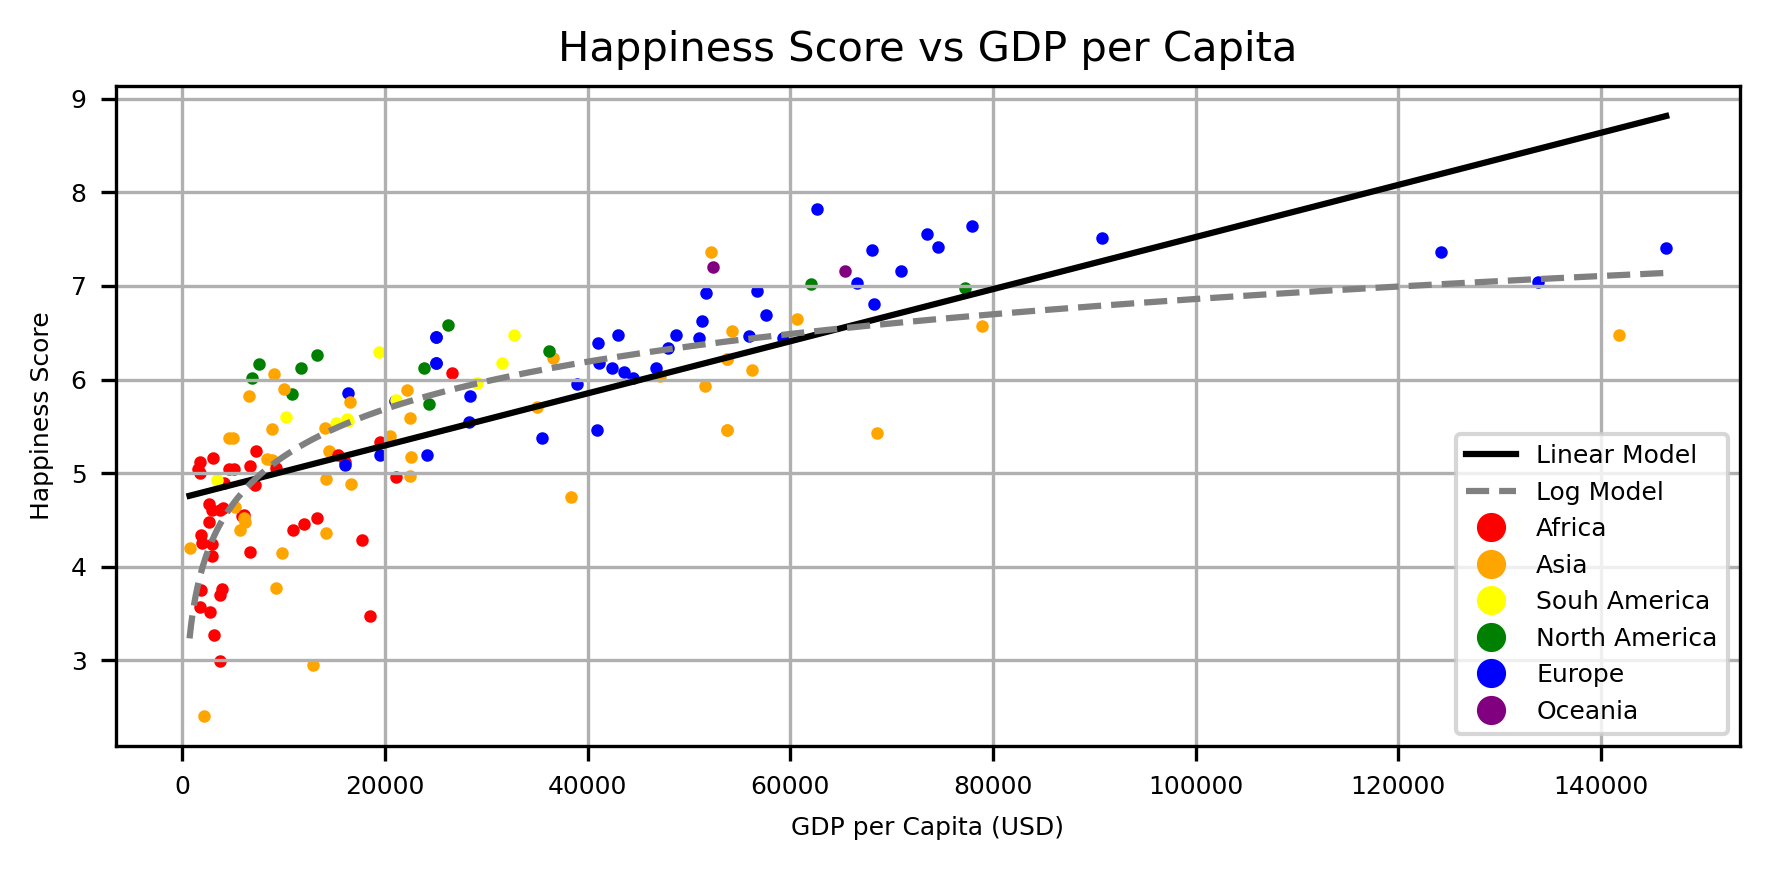

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))

plot_gdp_happiness(ax)

plt.tight_layout()
plt.show()

### World Happiness Distribution

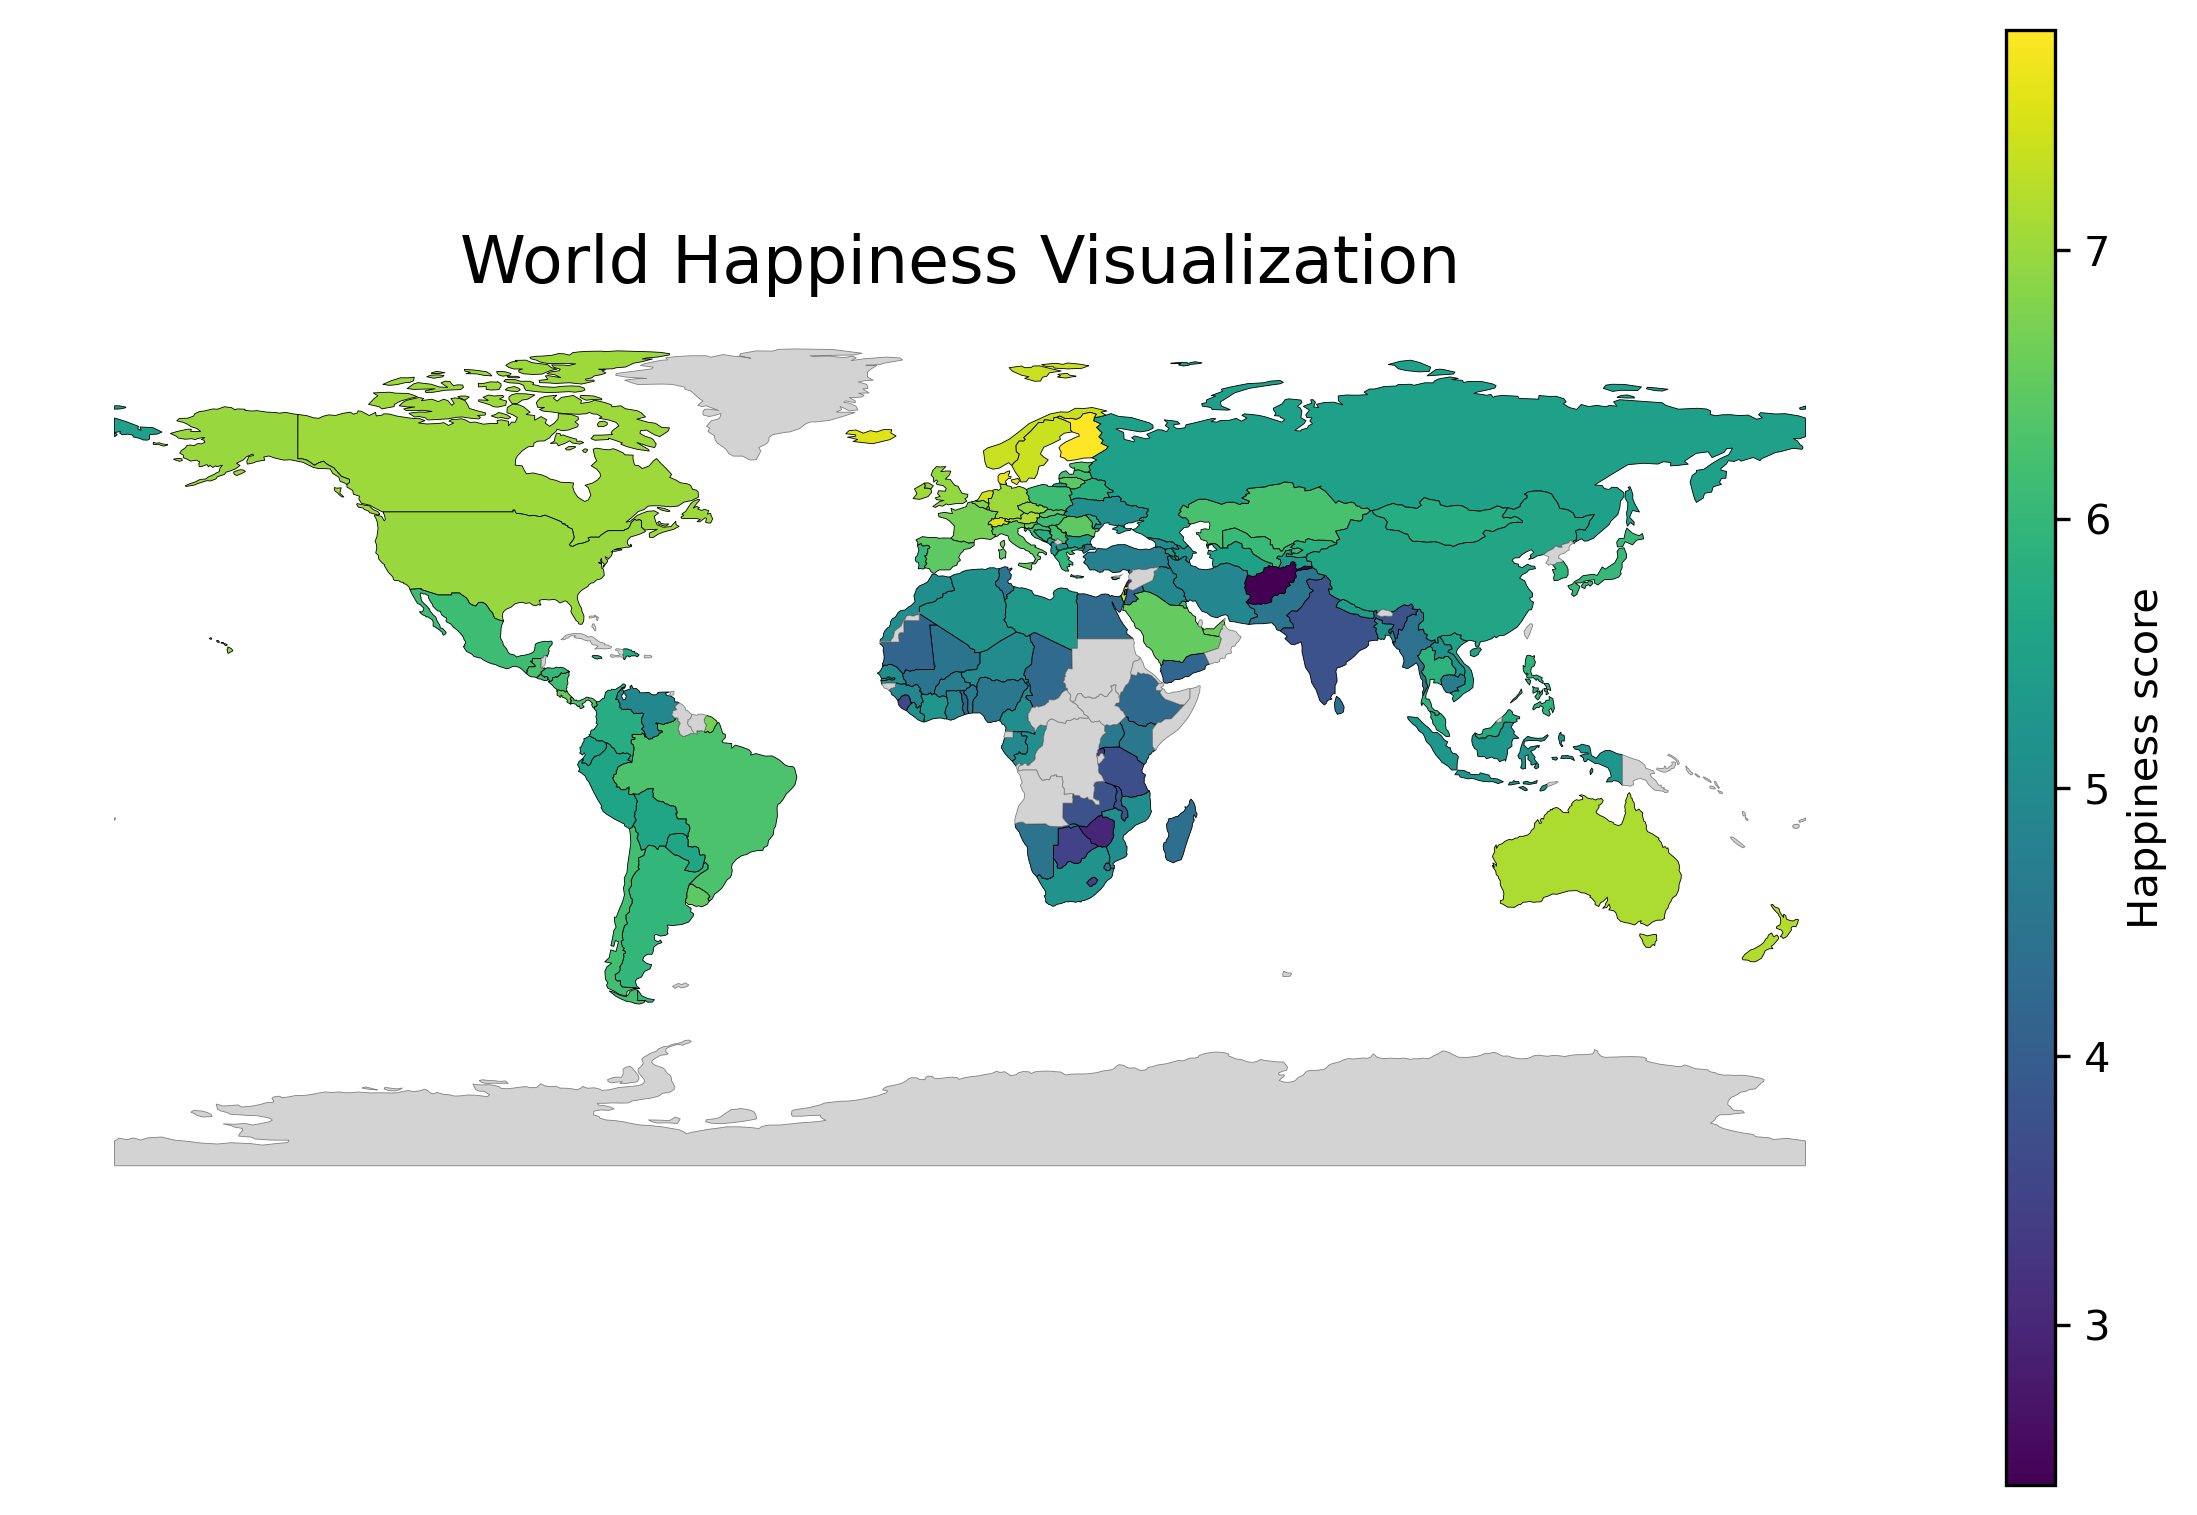

In [35]:
data = pd.read_csv(DATA_DIR + '90complete.csv')
gplotter = GeoPlotter(data)
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
gplotter.plot('Happiness score', ax=ax, title='World Happiness Visualization')
plt.show()

## Run Mutual Information Experiment

In [38]:
data = pd.read_csv(DATA_DIR + '90complete.csv')
data = data.drop('ISO_A3', axis=1)
col1 = 'Happiness score'
col2 = 'NY.GDP.PCAP.PP.KD'

print("Alpha = 0.01")
fs = FeatureSeparator(data, similarity_metric="mi", alpha=0.01)
cols, Ds, Xs, Ys = fs.get_separating_feature(col1, col2, n=10)
print("Most similar features: ", cols)
print("Similarity scores for Ds", Ds)
print("Similarity scores for Xs", Xs)
print("Similarity scores for Ys", Ys)

print("\nAlpha = 0.75")
fs = FeatureSeparator(data, similarity_metric="mi", alpha=0.75)
cols, Ds, Xs, Ys = fs.get_separating_feature(col1, col2, n=10)
print("Most similar features: ", cols)
print("Similarity scores for Ds", Ds)
print("Similarity scores for Xs", Xs)
print("Similarity scores for Ys", Ys)

Alpha = 0.01
Similarity of D with X [3.05707823]
Similarity of X with X [3.71716383]
Most similar features:  Index(['NY.GDP.PCAP.KD', 'NY.GNP.PCAP.CD', 'NY.GDP.PCAP.CD',
       'NY.GDP.PCAP.PP.CD', 'SH.DYN.0509', 'VA.PER.RNK', 'NY.GNP.PCAP.PP.CD',
       'VA.EST', 'SP.DYN.LE00.IN', 'VA.PER.RNK.UPPER'],
      dtype='object')
Similarity scores for Ds [0.67422968 0.66929627 0.63677701 0.62254214 0.60565605 0.59102853
 0.57802256 0.57711945 0.57468572 0.56680539]
Similarity scores for Xs [0.75489636 0.70259315 0.69417491 0.58493069 0.52277333 0.50135703
 0.57017661 0.51635363 0.50092754 0.51063536]
Similarity scores for Ys [1.67316076 1.75166999 1.8719084  3.49399959 0.76606191 0.49042514
 2.92215915 0.52109964 0.7422801  0.51389939]

Alpha = 0.75
Similarity of D with X [0.44930402]
Similarity of X with X [3.71716383]
Most similar features:  Index(['VA.PER.RNK.LOWER', 'SP.POP.1564.FE.ZS', 'VA.PER.RNK.UPPER', 'VA.EST',
       'VA.PER.RNK', 'SP.DYN.LE00.FE.IN', 'SP.DYN.IMRT.FE.IN',
       'S